In [1]:
import requests
import joblib
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pandas import option_context
from tqdm import tqdm
from statsmodels.stats.inter_rater import aggregate_raters
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mannwhitneyu,shapiro,ttest_ind

import cliffsDelta as cd
import GenerateActivities as gat
import important_features as imf

In [2]:
QUERY_ROOT = "https://api.github.com"
TOKEN = 'hidden' # write your GitHub API key here
HEADERS={'Authorization':'token '+TOKEN}

## Section 3

### Question 1

#### Write an automated Python script to identify all GitHub bot actors in the list of contributors, by querying the GitHub REST API users endpoint and extracting the required information to make this decision. 

#### More information: You can search for the "type" key in the obtianed JSON result, If it is "Bot", then it is a bot actor, if it is "User", then it is an account.

In [3]:
# 1. Read the given <sample>.csv file into a pandas DataFrame (df).
# 2. Make sure there are 2 columns, one column name is "contributor" that has the name of the contributor, 
#    and another column name is "bothunter_type" that you will use later on in this assignment.
# 3. Display the DataFrame.
import os

folder_path = 'Contributors'
file_name = 'sample21.csv'
file_path = os.path.join(folder_path, file_name)

df = pd.read_csv(file_path)
df.columns = ['contributor', 'bothunter_type']
print("DataFrame original :")
print(df)

DataFrame original :
                contributor bothunter_type
0              Charlie-XIAO          Human
1                 Illviljan          Human
2               OmarManzoor          Human
3                 Stars1233          Human
4                  abretaud          Human
5      allcontributors[bot]            Bot
6                   anntzer          Human
7                   benbovy          Human
8                  canergen          Human
9                chainer-ci            Bot
10                 commit-0          Human
11                coveralls            Bot
12                   dannon          Human
13          dependabot[bot]            Bot
14             editorialbot          Human
15                  emdupre          Human
16                  gil2rok          Human
17  github-merge-queue[bot]            Bot
18                    huard          Human
19              imagesc-bot            Bot
20                    jef-n          Human
21              jromanowska      

In [4]:
# 1. Store the names of the contributors in a list
# 2. print the list

contributors_list = df['contributor'].tolist()
print("Liste des contributeurs :")
print(contributors_list)

Liste des contributeurs :
['Charlie-XIAO', 'Illviljan', 'OmarManzoor', 'Stars1233', 'abretaud', 'allcontributors[bot]', 'anntzer', 'benbovy', 'canergen', 'chainer-ci', 'commit-0', 'coveralls', 'dannon', 'dependabot[bot]', 'editorialbot', 'emdupre', 'gil2rok', 'github-merge-queue[bot]', 'huard', 'imagesc-bot', 'jef-n', 'jromanowska', 'kmuehlbauer', 'lucianopaz', 'lumberbot-app[bot]', 'max-de-rooij', 'meeseeksmachine', 'mergify[bot]', 'mooniean', 'nanosoldier', 'netlify[bot]', 'nmauri', 'pangeo-bot', 'pavanvidem', 'rcannood', 'sckott', 'supernord', 'tylerjereddy', 'welcome[bot]', 'ymzayek']


In [5]:
# 1. Using a for loop, iterate over each contributor in the list and query the GitHub Users API.
#    You can use "query = f'{QUERY_ROOT}/users/{contributor}'", where QUERY_ROOT is defined at the beginning of this notebook 
#    and 'contributor' is each individual contributor from the list
# 2. Get the response using 'response = requests.get(query, headers=HEADERS)'.
# 3. convert the response to JSON using 'json_response = response.json()'.
# 4. Iterate over each JSON response and get the value of the 'type' key. If it is "Bot" then the contributor is a bot actor, 
#    if "User" then the contributor is an account. You should boolean values to indicate if the contributor is a bot actor (True) or User/Organisation (False)
# 5. Save these results in list of dictionary of the form [{'contributor': <contributor name>, 'app': <boolean value>}, {...}, {...}, {...}].
#    Lets call this list as "app_dict"
# 6. Finally convert this list of dictionary to DataFrame by writing 'pd.DataFrame.from_dict(app_dict)'
# 7. Display the DataFrame. This should have two columns - contributor and app

app_dict = []

for contributor in contributors_list:
    query = f'{QUERY_ROOT}/users/{contributor}'
    try:
        response = requests.get(query, headers=HEADERS)
        
        if response.status_code == 200:
            json_response = response.json()
            
            user_type = json_response.get('type', 'User')
            is_bot = True if user_type == "Bot" else False
            
            app_dict.append({'contributor': contributor, 'app': is_bot})
        else:
            print(f"Erreur lors de la récupération des données pour {contributor}: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Problème de connexion avec {contributor}: {e}")


app_df = pd.DataFrame.from_dict(app_dict)
print("DataFrame des résultats :")
print(app_df)

DataFrame des résultats :
                contributor    app
0              Charlie-XIAO  False
1                 Illviljan  False
2               OmarManzoor  False
3                 Stars1233  False
4                  abretaud  False
5      allcontributors[bot]   True
6                   anntzer  False
7                   benbovy  False
8                  canergen  False
9                chainer-ci  False
10                 commit-0  False
11                coveralls  False
12                   dannon  False
13          dependabot[bot]   True
14             editorialbot  False
15                  emdupre  False
16                  gil2rok  False
17  github-merge-queue[bot]   True
18                    huard  False
19              imagesc-bot  False
20                    jef-n  False
21              jromanowska  False
22              kmuehlbauer  False
23               lucianopaz  False
24       lumberbot-app[bot]   True
25             max-de-rooij  False
26          meeseeksmachine  

### Question 2

#### Add a new 'actor' column in the CSV file to store this information. You can write True if it is a bot actor and False if it is not.

#### Report on the total number of GitHub bot actors, and User accounts present in the list of accounts of your dataset.

In [6]:
print("Colonnes de df :", df.columns)
print("Colonnes de app_df :", app_df.columns)

Colonnes de df : Index(['contributor', 'bothunter_type'], dtype='object')
Colonnes de app_df : Index(['contributor', 'app'], dtype='object')


In [7]:
# Merge the app DataFrame to df by writing 'pd.merge(df, <app df>, on='contributor'). This is similar to SQL join on primary key 'contributor'.
# The resultant df should have 3 columns - contributor, bothunter_type and user_type.

merged_df = pd.merge(df, app_df, on='contributor')

# Afficher le DataFrame fusionné
print("DataFrame fusionné :")
print(merged_df)

DataFrame fusionné :
                contributor bothunter_type    app
0              Charlie-XIAO          Human  False
1                 Illviljan          Human  False
2               OmarManzoor          Human  False
3                 Stars1233          Human  False
4                  abretaud          Human  False
5      allcontributors[bot]            Bot   True
6                   anntzer          Human  False
7                   benbovy          Human  False
8                  canergen          Human  False
9                chainer-ci            Bot  False
10                 commit-0          Human  False
11                coveralls            Bot  False
12                   dannon          Human  False
13          dependabot[bot]            Bot   True
14             editorialbot          Human  False
15                  emdupre          Human  False
16                  gil2rok          Human  False
17  github-merge-queue[bot]            Bot   True
18                    huard  

### Question 3

#### For each bot actor, write their purpose, the task that they automate by looking at their GitHub profile, homepage, information on the GitHub Marketplace, or other documentation that you can find online.


1. allcontributors[bot]
Purpose: Manages contributions in open-source projects.
Tasks: Automatically adds contributors to a project's contributor list based on their contributions.

2. dependabot[bot]
Purpose: Manages dependencies in open-source projects.
Tasks: Automatically updates dependencies in a project based on the specified configuration.

3. github-merge-queue[bot]
Purpose: Manages pull requests in open-source projects.
Tasks: Automatically merges pull requests based on the specified configuration.

4. lumberbot-app[bot]
Purpose: Manages permissions and backports pull requests across repositories.
Tasks: Responds to commands, grants fine-grained user permissions, and assists in cross-repository workflows. Primarily developed for the Jupyter/IPython team.

5. mergify[bot]
Purpose: Automates pull request management in repositories.
Tasks: Merges, rebases, or closes pull requests based on defined rules. Helps maintain CI/CD workflows efficiently.

6. netlify[bot]
Purpose: Manages deployments and previews for Netlify-hosted projects.
Tasks: Triggers automatic deployments, provides preview links for pull requests, and reports build statuses.

7. welcome[bot]
Purpose: Greets and guides new contributors in open-source projects.
Tasks: Posts welcome messages, shares contribution guidelines, and offers helpful links to first-time contributors.


## Section 4

### Question 1

#### Write an automated script to use BIMBAS (Bot Identification Model Based on Activity Sequences) to obtain a prediction of the GitHub contributor type (Bot or Human) for the contributors present in your dataset.

#### Folow the steps given in each cell to use BIMBAS and obtain predictions.

### Read all the events and select the events performed by the contributors present in the given set

In [8]:
# 1. Read the csv file of events (all_events.csv) provided along with this notebook
# 2. Convert created_at column to datetime format 
#    One possible way is to use lambda function: "events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))"
# 3. Get the contributors provided to you in a list or use the contributors list that you created in Section 3 Question 1. 
#    e.g., ['contributor1', 'contributor2', 'contributor3',...]
# 4. Select the events performed by these contributors alone. Do not consider all the events. You should consider only the events
#    performed by the contributors provided to you. Hint: you can use the df.query function
# 5. Display the considered events.

events_file = 'all_events.csv'
events_df = pd.read_csv(events_file)

events_df = events_df.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))

print("DataFrame des événements :")
print(events_df.head())

events_df

filtered_events = events_df.query('login in @contributors_list')

print("Événements considérés :")
print(filtered_events)


DataFrame des événements :
   Unnamed: 0     event_id                     event_type         login  \
0           0  39747377940         PullRequestReviewEvent       mdhaber   
1           1  39747377910         PullRequestReviewEvent       mdhaber   
2           2  39747378053                      PushEvent      siko1056   
3           3  39747379822              IssueCommentEvent  codecov[bot]   
4           4  39747384737  PullRequestReviewCommentEvent      chaoyihu   

                    repository          created_at   action  PR_number state  \
0                  scipy/scipy 2024-07-01 00:00:03  created    21087.0  open   
1                  scipy/scipy 2024-07-01 00:00:03  created    21087.0  open   
2  gnu-octave/packages-sandbox 2024-07-01 00:00:03      NaN        NaN   NaN   
3                napari/napari 2024-07-01 00:00:10  created     7043.0  open   
4            pandas-dev/pandas 2024-07-01 00:00:34  created    59145.0  open   

            PR_node_id  ...        commen

In [9]:
filtered_events

,Unnamed: 0,event_id,event_type,login,repository,created_at,action,PR_number,state,PR_node_id,...,comment_node_id,merged,ref,ref_type,issue_number,issue_node_id,issue_closed_at,tag_name,release_node_id,org
19,19,39747424767,PushEvent,tylerjereddy,scipy/devdocs,2024-07-01 00:04:29,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,scipy
64,64,39747593861,IssueCommentEvent,netlify[bot],QuantEcon/lecture-python-intro,2024-07-01 00:20:10,created,493.0,open,PR_kwDOIy5DFs50AAal,...,IC_kwDOIy5DFs6DD2NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QuantEcon
163,163,39747766396,CreateEvent,dependabot[bot],SciML/EasyModelAnalysis.jl,2024-07-01 00:34:53,NaN,NaN,NaN,NaN,...,NaN,NaN,dependabot/github_actions/actions/add-to-proje...,branch,NaN,NaN,NaN,NaN,NaN,SciML
164,164,39747766717,PullRequestEvent,dependabot[bot],SciML/EasyModelAnalysis.jl,2024-07-01 00:34:55,opened,261.0,open,PR_kwDOI1YYHs50AC5Y,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SciML
360,360,39748962606,DeleteEvent,editorialbot,openjournals/joss-papers,2024-07-01 02:00:22,NaN,NaN,NaN,NaN,...,NaN,NaN,joss.06287,branch,NaN,NaN,NaN,NaN,NaN,openjournals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358372,358372,42415163035,PushEvent,editorialbot,openjournals/joss-papers,2024-09-30 23:15:30,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openjournals
358373,358373,42415164195,PullRequestEvent,editorialbot,openjournals/joss-papers,2024-09-30 23:15:35,opened,5944.0,open,PR_kwDOA31exc59LiE8,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openjournals
358374,358374,42415166170,IssueCommentEvent,editorialbot,openjournals/joss-reviews,2024-09-30 23:15:43,created,NaN,open,NaN,...,IC_kwDOAx6EUs6OHpbv,NaN,NaN,NaN,7256.0,I_kwDOAx6EUs6XbOF-,NaN,NaN,NaN,openjournals
358420,358420,42415587765,IssueCommentEvent,welcome[bot],pydata/xarray,2024-09-30 23:41:50,created,9561.0,open,PR_kwDOAMm_X859Ls6n,...,IC_kwDOAMm_X86OIA0y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pydata


### Execute BIMBAS to obtain the predictions

In [10]:
contributors_list

['Charlie-XIAO',
 'Illviljan',
 'OmarManzoor',
 'Stars1233',
 'abretaud',
 'allcontributors[bot]',
 'anntzer',
 'benbovy',
 'canergen',
 'chainer-ci',
 'commit-0',
 'coveralls',
 'dannon',
 'dependabot[bot]',
 'editorialbot',
 'emdupre',
 'gil2rok',
 'github-merge-queue[bot]',
 'huard',
 'imagesc-bot',
 'jef-n',
 'jromanowska',
 'kmuehlbauer',
 'lucianopaz',
 'lumberbot-app[bot]',
 'max-de-rooij',
 'meeseeksmachine',
 'mergify[bot]',
 'mooniean',
 'nanosoldier',
 'netlify[bot]',
 'nmauri',
 'pangeo-bot',
 'pavanvidem',
 'rcannood',
 'sckott',
 'supernord',
 'tylerjereddy',
 'welcome[bot]',
 'ymzayek']

In [11]:
# Do not modify this cell
# Use the following function the code below to obtain your predictions

def execute_bimbas(contributors_list, selected_events):
    '''
    args: contributors_list (list) - list of contributors in the dataset provided to you
          selected_events (DataFrame) - DataFrame of events performed by the considered contributors
    return: bimbas_prediction (DataFrame) - DataFrame of preditions along with the confidence in prediction for each contributor
    '''
    result=pd.DataFrame()
    temp_list = []
    bimbas = joblib.load('bimbas.joblib')
    date_limit = pd.to_datetime(selected_events.created_at.max()) + pd.DateOffset(-90)
    
    for contributor in tqdm(contributors_list):
        # c = contributors[contributor]
        activities = gat.activity_identification(selected_events.query('login==@contributor and created_at>=@date_limit'))
        activity_features = (
                            imf.extract_features(activities)
                            .set_index([[contributor]])
                            )
        # features = pd.concat([features,activity_features])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            probability = bimbas.predict_proba(activity_features)[0][1]
        if(probability <= 0.5):
            contributor_type = 'Human'
        else:
            contributor_type = 'Bot'
        confidence = (abs(probability - 0.5)*2).round(3)
    
        pred = activity_features.set_index([[contributor]]).assign(
            prediction=contributor_type,
            confidence = confidence,
            )
        temp_list.extend([{'contributor':contributor,'bimbas_type':contributor_type,'confidence':confidence}])
    
    bimbas_prediction = pd.DataFrame.from_dict(temp_list)

    return(bimbas_prediction)

In [12]:
# Write your code here to call execute_bimbas function. 
# Pass the contributors list and the filtered events DataFrame as argument to "execute_bimbas" function
# Prediction returned by BIMBAS will have "contributor", "bimbas_type" and "confidence"
# Note: Print the prediction provided by BIMBAS - else this cell will not be graded.

bimbas_predictions = execute_bimbas(contributors_list, filtered_events)
print(bimbas_predictions)

100%|██████████| 40/40 [00:14<00:00,  2.85it/s]

                contributor bimbas_type  confidence
0              Charlie-XIAO       Human       0.906
1                 Illviljan       Human       0.943
2               OmarManzoor       Human       0.797
3                 Stars1233       Human       0.778
4                  abretaud       Human       0.824
5      allcontributors[bot]         Bot       0.567
6                   anntzer       Human       0.943
7                   benbovy       Human       0.887
8                  canergen       Human       0.810
9                chainer-ci         Bot       0.723
10                 commit-0         Bot       0.857
11                coveralls         Bot       0.910
12                   dannon       Human       0.851
13          dependabot[bot]         Bot       0.834
14             editorialbot         Bot       0.471
15                  emdupre         Bot       0.923
16                  gil2rok       Human       0.953
17  github-merge-queue[bot]         Bot       0.794
18          

### Create a column in your predictions DataFrame to have predictions provided by BIMBAS. 
### Now your DataFrame should have the following columns - contributor, bothunter_type, app, bimbas_type, confidence 

### Merging bothunter and bimbas predictions

In [13]:
# Merge the predictions provided by BIMBAS to the resultant dataset of Section 3. This final DataFrame should have the following columns - 
# contributor, bothunter_type, user_type, bimbas_type, and confidence.

final_predictions = pd.merge(merged_df, bimbas_predictions, on='contributor', how='left')


print(final_predictions)

                contributor bothunter_type    app bimbas_type  confidence
0              Charlie-XIAO          Human  False       Human       0.906
1                 Illviljan          Human  False       Human       0.943
2               OmarManzoor          Human  False       Human       0.797
3                 Stars1233          Human  False       Human       0.778
4                  abretaud          Human  False       Human       0.824
5      allcontributors[bot]            Bot   True         Bot       0.567
6                   anntzer          Human  False       Human       0.943
7                   benbovy          Human  False       Human       0.887
8                  canergen          Human  False       Human       0.810
9                chainer-ci            Bot  False         Bot       0.723
10                 commit-0          Human  False         Bot       0.857
11                coveralls            Bot  False         Bot       0.910
12                   dannon          H

### Question 2
#### Using Cohen's Kappa compute and report the interrater agreement score between the labels computed by both the bot identification approaches. Mention your interpretation of Cohen's Kappa

In [14]:
# Hint: use the cohen_kappa_score library

approach_1 = final_predictions['bothunter_type']
approach_2 = final_predictions['bimbas_type']

kappa_score = cohen_kappa_score(approach_1, approach_2)

print(f"Cohen's Kappa Score: {kappa_score:.3f}")

# Interprétation du score
if kappa_score <= 0:
    interpretation = "No agreement"
elif kappa_score <= 0.2:
    interpretation = "Slight agreement"
elif kappa_score <= 0.4:
    interpretation = "Fair agreement"
elif kappa_score <= 0.6:
    interpretation = "Moderate agreement"
elif kappa_score <= 0.8:
    interpretation = "Substantial agreement"
else:
    interpretation = "Perfect agreement"

print(f"Interpretation: {interpretation}")


Cohen's Kappa Score: 0.439
Interpretation: Moderate agreement


### Question 3
#### Determine the final type of each contributor. Whenever user_type column has the value "User" check if both bimbas_type and bothunter_type give the same prediction, then consider it as your final prediction in "acc_type" column.
#### For the contributors that have different predictions, i.e. bimbas_type is not same as bothunter_type, then make a manual verification and consider that as the type for that contributor. Add an extra column to the DataFrame ﬁle called 'manual' that has the label determined by you. 
#### For manual verification you can make use the GitHub UI and the GitHub API https://api.github.com/users/username

#### Whenever user_type column has the value "Bot", directly write your final acc_type as "Bot Actor"

#### More information:
For each contributor, you can look at their activities in GitHub UI, look at their latest events using GitHub Events API - https://api.github.com/users/<contributor>/events, to make a decision on their type.

In addition, you can also write a very small reason why do you think they are bot or human (e.g., same activity at regular interval so Bot, files committed and code modified looks like Human, comments look like Human, comment look like Bot, test report looks automated so Bot, and so on....). This will be useful to answer your next question.

In [15]:
final_predictions = final_predictions.rename(columns={'app': 'user_type'})

In [16]:
# Write the code for your manual decision here
# example : 
# manual_list_dict = [{'contributor': '<contributor name>', 'manual': '<your prediction>'}, {....}, {....}, {....}]
# pd.DataFrame.from_dict(manual_list_dict)


manual_list_dict = []

def get_github_events(username):
    url = f'https://api.github.com/users/{username}/events'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return []


def manual_decision(contributor, bimbas_type, bothunter_type):
    events = get_github_events(contributor)
    
    if len(events) > 0:
        for event in events:
            if 'push' in event['type'].lower() or 'pull_request' in event['type'].lower():
                
                return "Human", "Reason: Regular commits and pull requests."
            elif 'issue' in event['type'].lower():
                return "Bot", "Reason: Automated issue comments."
    return "Bot", "Reason: No significant activity, likely bot."

In [17]:
# Write your code below here to determine the final type of contributor.
# add column named 'acc_type' and write your final decision in it. Final decision is majority of three types - bimbas_type, bothunter_type, manual.

final_predictions['acc_type'] = final_predictions.apply(
    lambda row: row['bimbas_type'] if row['user_type'] == 'User' and row['bimbas_type'] == row['bothunter_type'] 
               else ('Bot Actor' if row['user_type'] == 'Bot' 
                     else manual_decision(row['contributor'], row['bimbas_type'], row['bothunter_type'])[0]),
    axis=1
)

final_predictions['manual'] = final_predictions.apply(
    lambda row: manual_decision(row['contributor'], row['bimbas_type'], row['bothunter_type'])[1] 
               if row['bimbas_type'] != row['bothunter_type'] else None,
    axis=1
)


print(final_predictions[['contributor', 'bimbas_type', 'bothunter_type', 'acc_type', 'manual']])


                contributor bimbas_type bothunter_type acc_type  \
0              Charlie-XIAO       Human          Human    Human   
1                 Illviljan       Human          Human      Bot   
2               OmarManzoor       Human          Human    Human   
3                 Stars1233       Human          Human    Human   
4                  abretaud       Human          Human    Human   
5      allcontributors[bot]         Bot            Bot      Bot   
6                   anntzer       Human          Human      Bot   
7                   benbovy       Human          Human      Bot   
8                  canergen       Human          Human      Bot   
9                chainer-ci         Bot            Bot      Bot   
10                 commit-0         Bot          Human    Human   
11                coveralls         Bot            Bot      Bot   
12                   dannon       Human          Human      Bot   
13          dependabot[bot]         Bot            Bot    Huma

### Question 4
#### Study and report the purpose of these identified bots and humans in the repository assigned to you.
#### For example, the purpose can be based on but not limited to - 
##### 1) the type of activities that they are performing (releasing a version on every Sunday, updating the documentation), 
##### 2) type of comments they are posting (reviewing code, test summary report), 
##### 3) when are they triggered (when a new PR is created, when someone in the project ask the bot to merge the code) and so on.  
#### Note: 
##### The purpose can be other than what is provided in examples above.

1. commit-0 is bot 

2. editorialbot is a bot that is our editorial bot that interacts with authors, reviewers, and editors on JOSS reviews.

3. emdupre is human (a postdoctoral researcher in the SIMEXP lab)

4.imagesc-bot is an inactive profile so its probably a bot

5.jromanowska is human, data analyst and bioinformatics expert at University of Bergen, Norway

## Section 5

### Question 1
#### Use the filtered events file that has the events performed by the contributors provided to you
#### Group each event into the following four categories

Issues: IssueCommentEvent, IssuesEvent  
Pull Requests: PullRequestEvent, PullRequestReviewCommentEvent  
Commits: CommitCommentEvent, PushEvent  
Repository: CreateEvent, DeleteEvent, ForkEvent, GollumEvent, MemberEvent, PublicEvent, ReleaseEvent, SponsorshipEvent, WatchEvent  

#### Hint:
1. Add a column called event_group that mentions which event group does that event belong to. Each event (row) should correspond to an event group.  
2. Then perform groupby on ['login','event_group'],  
3. use .agg (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) to count the number of events performed by each contributor in each group,  
4. use pivot with the required arguments (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html). An example is given [here](#pivot_example) in question 2(b), and
5. Reset index and rename axis with None
7. Finally merge it with your 'acc_type' field from the DataFrame you created in Section4, drop contributor, and fillna with 0
8. The final DataFrame should have the following columns - login, PR, commit, issue, repo, acc_type

The final DataFrame should be looking like the following  
![](event_group.png)

In [18]:
# In the resultant DataFrame - each row should corespond to a contributor, and the columns should have all the event groups  
# and the type of the contributor (that you decided in the previous DataFrame) and the values should be the number 
# of events of that event event group the contriubutor has performed.

issue_group = ['IssueCommentEvent', 'IssuesEvent']
pr_group = ['PullRequestEvent', 'PullRequestReviewCommentEvent']
commit_group = ['CommitCommentEvent', 'PushEvent']
repo_group = ['CreateEvent', 'DeleteEvent', 'ForkEvent', 'GollumEvent', 'MemberEvent', 'PublicEvent', 'ReleaseEvent', 'SponsorshipEvent', 'WatchEvent']

In [53]:
event_group_mapping = {
    'IssueCommentEvent': 'Issues',
    'IssuesEvent': 'Issues',
    'PullRequestEvent': 'Pull Requests',
    'PullRequestReviewCommentEvent': 'Pull Requests',
    'CommitCommentEvent': 'Commits',
    'PushEvent': 'Commits',
    'CreateEvent': 'Repository',
    'DeleteEvent': 'Repository',
    'ForkEvent': 'Repository',
    'GollumEvent': 'Repository',
    'MemberEvent': 'Repository',
    'PublicEvent': 'Repository',
    'ReleaseEvent': 'Repository',
    'SponsorshipEvent': 'Repository',
    'WatchEvent': 'Repository'
}

filtered_events['event_group'] = filtered_events['event_type'].map(event_group_mapping)

event_counts = filtered_events.groupby(['login', 'event_group']).size().reset_index(name='count')

pivot_df = event_counts.pivot(index='login', columns='event_group', values='count').fillna(0)

pivot_df.columns = ['Commits', 'Issues', 'Pull Requests', 'Repository']

final_predictions.rename(columns={'contributor': 'login'}, inplace=True)

final_df = pd.merge(pivot_df, final_predictions[['login', 'acc_type']], on='login', how='left')

final_df = final_df[['login', 'Pull Requests', 'Commits', 'Issues', 'Repository', 'acc_type']]


print(final_df)


                      login  Pull Requests  Commits  Issues  Repository  \
0              Charlie-XIAO           61.0      3.0    73.0         2.0   
1                 Illviljan           63.0     14.0    41.0         0.0   
2               OmarManzoor          150.0     21.0    65.0         4.0   
3                 Stars1233            0.0      0.0     0.0        15.0   
4                  abretaud            5.0      2.0     8.0         0.0   
5      allcontributors[bot]           10.0     23.0    10.0        10.0   
6                   anntzer           26.0      4.0    47.0         0.0   
7                   benbovy            2.0      0.0    14.0         0.0   
8                  canergen          150.0     67.0   169.0        32.0   
9                chainer-ci           49.0      0.0     9.0         0.0   
10                 commit-0            0.0      0.0     0.0        35.0   
11                coveralls            0.0      0.0   268.0         0.0   
12                   dann

/var/folders/gn/9sld9f355q5_q7h8pbqc1v5w0000gn/T/ipykernel_48256/4028172719.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_events['event_group'] = filtered_events['event_type'].map(event_group_mapping)


### Question 2 (a)

#### Compute the median number of events per event group for Bot+Bot actors and Humans and write in DataFrame.

Row should correspond to type (Bot_BotActor and Human), Column should have Event group name and the values should be the median value of Bot_BotActor or Human for that particular event group. An example is given below

In [45]:
# For example:
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot_app'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot_app
1,event_group1,val2,Human
2,event_group2,val3,Bot_app
3,event_group2,val4,Human
4,event_group3,val5,Bot_app
5,event_group3,val6,Human
6,event_group4,val7,Bot_app
7,event_group5,val8,Human


In [ ]:
medians = []
event_groups = ['Commits', 'Issues', 'Pull Requests', 'Repository']


for acc_type in ['Bot', 'Human']:

    filtered_df = final_df[final_df['acc_type'] == acc_type]
    
    for event_group in event_groups:
        median_value = filtered_df[event_group].median()
        medians.append({
            'event_group': event_group, 
            'median': median_value, 
            'acc_type': acc_type
        })

df_medians = pd.DataFrame(medians)

df_medians_pivot = df_medians.pivot(index='acc_type', columns='event_group', values='median')

df_medians_pivot.reset_index(inplace=True)

df_medians_pivot


KeyError: 'login'

### Question 2 (b)

Plot a heatmap of the DataFrame using seaborn - 
1. First convert the dataframe to the required format using pivot, example is given below
2. plot using seaborn - sns.heatmap(df_medians, annot=True, vmin=0, vmax=300, cmap="crest"). More details: https://seaborn.pydata.org/generated/seaborn.heatmap.html)

#### pd.pivot example:
<a id='pivot_example'></a>

In [47]:
# Main DataFrame
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot
1,event_group1,val2,Human
2,event_group2,val3,Bot
3,event_group2,val4,Human
4,event_group3,val5,Bot
5,event_group3,val6,Human
6,event_group4,val7,Bot
7,event_group5,val8,Human


In [48]:
# pivot the main DataFrame
df_medians.pivot(index='acc_type', columns='event_group', values='median')#.reset_index().rename_axis(None,axis=1)

event_group,event_group1,event_group2,event_group3,event_group4,event_group5
acc_type,,,,,
Bot,val1,val3,val5,val7,NaN
Human,val2,val4,val6,NaN,val8


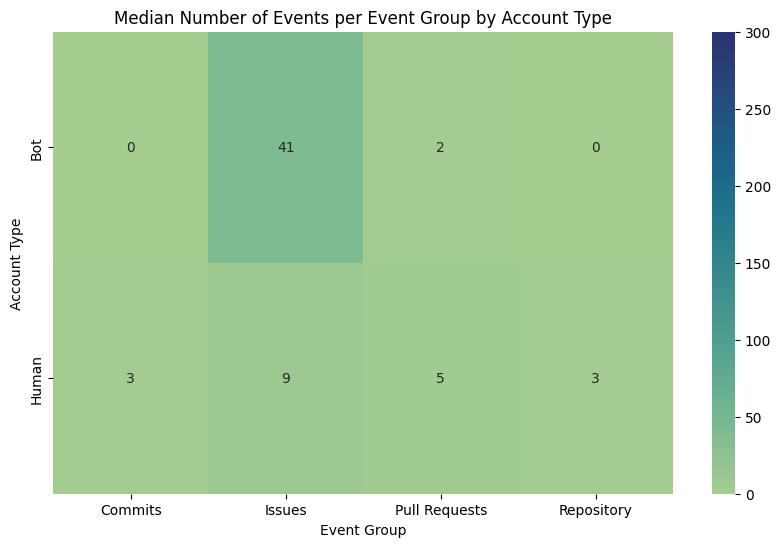

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_medians_pivot.set_index('acc_type'), annot=True, cmap="crest", vmin=0, vmax=300)

plt.title('Median Number of Events per Event Group by Account Type')
plt.xlabel('Event Group')
plt.ylabel('Account Type')

plt.show()

#### What is the difference that you observe between Bots+Bot actors and Humans?

In [63]:
df_medians_pivot

event_group,acc_type,Commits,Issues,Pull Requests,Repository
0,Bot,0.0,41.0,2.0,0.0
1,Human,3.0,9.0,5.0,3.0


Bots tend to be more active in issue-related activities, with a higher median value for issues (41) compared to Humans (9). However, Bots have little involvement in commits and repositories, with a median of 0 for both, while Humans contribute more to these areas, with a median of 3 for commits and 3 for repositories. For pull requests, Bots show some activity with a median of 2, but Humans contribute slightly more with a median of 5. Overall, Humans are more balanced across the different event groups, while Bots are more focused on issues.

#### What is the differnce that you observe between Event groups?

The key difference between event groups is that Bots are more active in Issues, with a median of 41, while Humans are more active in Commits (median of 3) and Pull Requests (median of 5). Both groups have low activity in Repository events, but Humans still show slightly more involvement. This suggests that Bots focus more on issue-related tasks, while Humans contribute more to code development and repository management.

#### What is the difference that you observe between Bots+Bot actors and Humans and Event groups all considering at the same time?

Bots are more active in handling Issues, while Humans focus more on Commits and Pull Requests. Bots have a higher median in Issues, suggesting they are used for automation or managing issues. Humans, on the other hand, are more engaged in development tasks like committing code and reviewing pull requests. Both have minimal involvement in Repository events, but Humans still show a slight edge. Overall, Bots handle more administrative tasks, while Humans are focused on the development process.

### Question 3

#### Create boxen plots to visualise the distribution of number of events in each event group. 
#### For more information you can visit - https://seaborn.pydata.org/generated/seaborn.boxenplot.html#seaborn.boxenplot 
#### You should highlight the data points that correspond to bots using a stripplot in seaborn. https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial  
#### Interpret the results of the visualisation.

/var/folders/gn/9sld9f355q5_q7h8pbqc1v5w0000gn/T/ipykernel_48256/3295224797.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='acc_type', y='Pull Requests', data=pull_requests_df, palette="Set2")


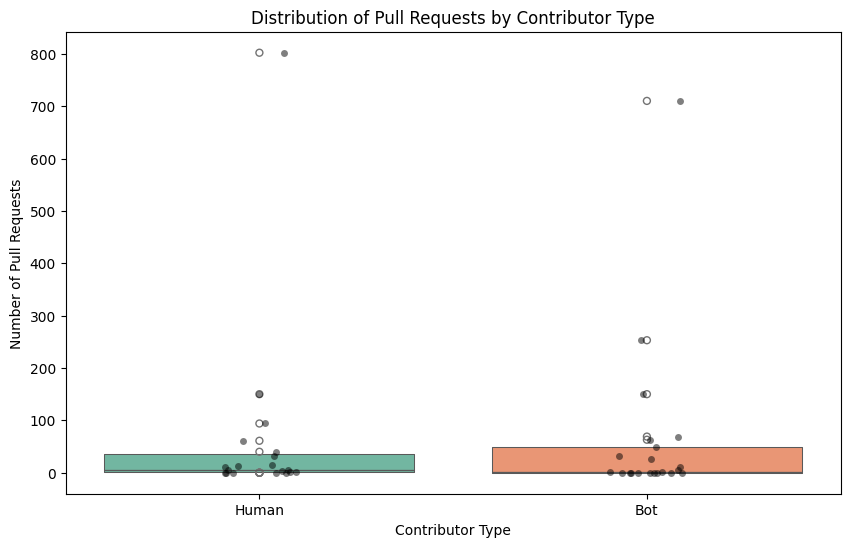

In [ ]:
# YOUR CODE BELOW - Visualize number of events from pull request event group

pull_requests_df = final_df[['acc_type', 'Pull Requests']]

plt.figure(figsize=(10, 6))
sns.boxenplot(x='acc_type', y='Pull Requests', data=pull_requests_df, palette="Set2")

sns.stripplot(x='acc_type', y='Pull Requests', data=pull_requests_df, jitter=True, color='black', alpha=0.5)

plt.title('Distribution of Pull Requests by Contributor Type')
plt.xlabel('Contributor Type')
plt.ylabel('Number of Pull Requests')

plt.show()



/var/folders/gn/9sld9f355q5_q7h8pbqc1v5w0000gn/T/ipykernel_48256/4131083232.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='acc_type', y='Issues', data=issues_df, palette="Set2")


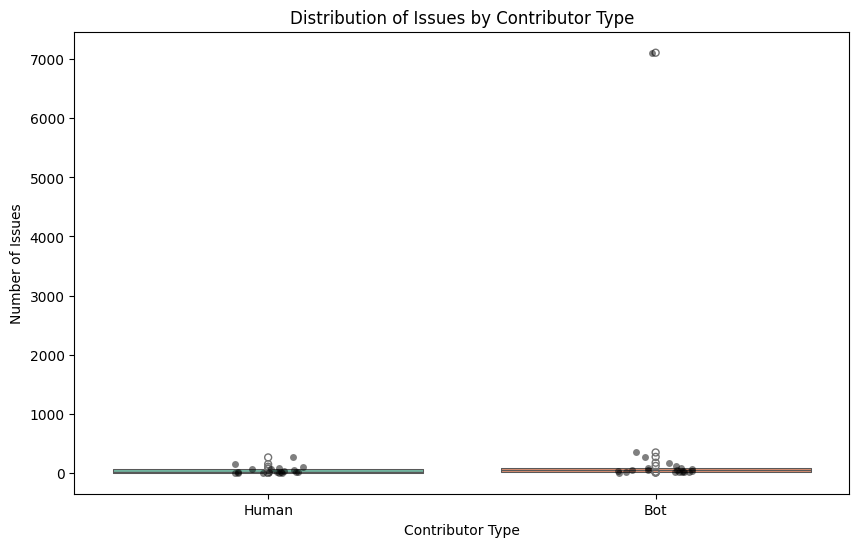

In [71]:
# YOUR CODE BELOW - Visualise number of events from issue event group

issues_df = final_df[['acc_type', 'Issues']]

plt.figure(figsize=(10, 6))
sns.boxenplot(x='acc_type', y='Issues', data=issues_df, palette="Set2")

sns.stripplot(x='acc_type', y='Issues', data=issues_df, jitter=True, color='black', alpha=0.5)

plt.title('Distribution of Issues by Contributor Type')
plt.xlabel('Contributor Type')
plt.ylabel('Number of Issues')

plt.show()

/var/folders/gn/9sld9f355q5_q7h8pbqc1v5w0000gn/T/ipykernel_48256/2305033488.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='acc_type', y='Commits', data=commits_df, palette="Set2")


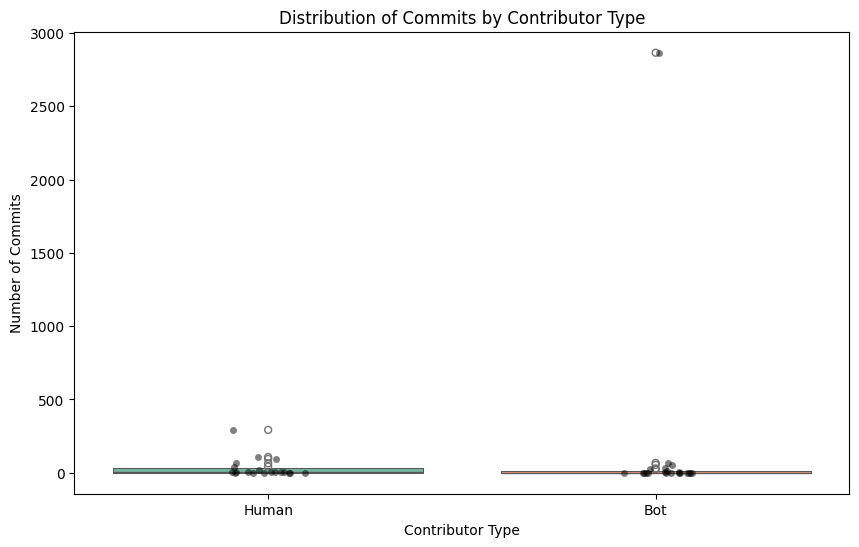

In [ ]:
# YOUR CODE BELOW - Visualise number of events from repo event group

commits_df = final_df[['acc_type', 'Commits']]

plt.figure(figsize=(10, 6))
sns.boxenplot(x='acc_type', y='Commits', data=commits_df, palette="Set2")

sns.stripplot(x='acc_type', y='Commits', data=commits_df, jitter=True, color='black', alpha=0.5)


plt.title('Distribution of Commits by Contributor Type')
plt.xlabel('Contributor Type')
plt.ylabel('Number of Commits')

plt.show()



### Question 4.1

#### Statistical identify whether number of events in each event group is normally distributed or not.
#### Null hypothesis - $H_0$: Sample comes from the data that has normal distribution.
#### Use Shapiro-Wilk test for this purpose. Use the p-value with a threshold of 0.05 to determine whether $H_0$ can be rejected with statistical significance or not. 

#### Use shapiro from scipy.stats to perform this test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

In [68]:
from scipy.stats import shapiro

event_groups = ['Commits', 'Issues', 'Pull Requests', 'Repository']

for event_group in event_groups:
    data = final_df[event_group]
    
    stat, p_value = shapiro(data)
    
    print(f'Event Group: {event_group}')
    print(f'Statistic: {stat:.4f}, p-value: {p_value:.4f}')

    if p_value < 0.05:
        print(f'Conclusion: Reject null hypothesis, the data is not normally distributed\n')
    else:
        print(f'Conclusion: Fail to reject null hypothesis, the data is normally distributed\n')


Event Group: Commits
Statistic: 0.1993, p-value: 0.0000
Conclusion: Reject null hypothesis, the data is not normally distributed

Event Group: Issues
Statistic: 0.1892, p-value: 0.0000
Conclusion: Reject null hypothesis, the data is not normally distributed

Event Group: Pull Requests
Statistic: 0.4230, p-value: 0.0000
Conclusion: Reject null hypothesis, the data is not normally distributed

Event Group: Repository
Statistic: 0.2305, p-value: 0.0000
Conclusion: Reject null hypothesis, the data is not normally distributed



### Question 4.2
#### Determine if there is any statistical diﬀerence in number of events between the identified event groups. Perform this test on all pairs of event groups. 
#### Null hypothesis - $H_0$: Any two event group come from the same population.
#### If $H_0$ is rejected in Shapiro-Wilk test (at least for one of the two event groups considered for test), use the Mann-Whitney U statistical test for this purpose. If $H_0$ is not rejected in Shapiro-Wilk test, use the independent t-test for this purpose.  
#### In any case, use the p-value with a threshold of 0.01 to determine whether $H_0$ can be rejected with statistical significance. 

#### Use mannwhitneyu from scipy.stats to perform Mann-Whitney U test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) 
#### or 
#### ttest_ind from scipy.stats to perform independent t-test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html.

#### More information:

You can pass the following arguments to mannwhitneyu from scipy.stats - (method='exact', nan_policy='omit'). For ttest_ind you can use - (nan_policy='omit')

In [69]:
# YOUR CODE BELOW
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

event_groups = ['Commits', 'Issues', 'Pull Requests', 'Repository']

for i in range(len(event_groups)):
    for j in range(i + 1, len(event_groups)):
        event_group1 = event_groups[i]
        event_group2 = event_groups[j]
        
        data1 = final_df[event_group1]
        data2 = final_df[event_group2]
        
        stat1, p_value1 = shapiro(data1)
        stat2, p_value2 = shapiro(data2)
        
        print(f'Comparing {event_group1} and {event_group2}')
        print(f'  Shapiro-Wilk Test p-values: {event_group1} = {p_value1:.4f}, {event_group2} = {p_value2:.4f}')
        
        if p_value1 < 0.01 or p_value2 < 0.01:
            stat, p_value = mannwhitneyu(data1, data2, method='exact', nan_policy='omit')
            test_type = 'Mann-Whitney U Test'
        else:
            stat, p_value = ttest_ind(data1, data2, nan_policy='omit')
            test_type = 'Independent t-test'
        
        print(f'  {test_type} p-value: {p_value:.4f}')
        
        if p_value < 0.01:
            print(f'  Conclusion: Reject null hypothesis, there is a significant difference\n')
        else:
            print(f'  Conclusion: Fail to reject null hypothesis, no significant difference\n')



Comparing Commits and Issues
  Shapiro-Wilk Test p-values: Commits = 0.0000, Issues = 0.0000
  Mann-Whitney U Test p-value: 0.0002
  Conclusion: Reject null hypothesis, there is a significant difference

Comparing Commits and Pull Requests
  Shapiro-Wilk Test p-values: Commits = 0.0000, Pull Requests = 0.0000
  Mann-Whitney U Test p-value: 0.2598
  Conclusion: Fail to reject null hypothesis, no significant difference

Comparing Commits and Repository
  Shapiro-Wilk Test p-values: Commits = 0.0000, Repository = 0.0000
  Mann-Whitney U Test p-value: 0.8072
  Conclusion: Fail to reject null hypothesis, no significant difference

Comparing Issues and Pull Requests
  Shapiro-Wilk Test p-values: Issues = 0.0000, Pull Requests = 0.0000
  Mann-Whitney U Test p-value: 0.0162
  Conclusion: Fail to reject null hypothesis, no significant difference

Comparing Issues and Repository
  Shapiro-Wilk Test p-values: Issues = 0.0000, Repository = 0.0000
  Mann-Whitney U Test p-value: 0.0000
  Conclusion:

### Question 4.3
#### Each time you reject the null hypothesis $H_0$, quantify the effect size of the diﬀerence between the groups using cliﬀ’s delta ($\delta$). 
#### To calculate cliﬀ’s delta, you can pass the list of values to cliﬀ delta.py file given in the repository. E.g., cliffsDelta.cliffsDelta(list of values, list of values). This will return the effect size.
#### Refer to the table given in the TP document and mention your interpretation (negligible, small, medium, large).

In [70]:
# YOU CODE BELOW
from cliffsDelta import cliffsDelta
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

event_groups = ['Commits', 'Issues', 'Pull Requests', 'Repository']

for i in range(len(event_groups)):
    for j in range(i + 1, len(event_groups)):
        event_group1 = event_groups[i]
        event_group2 = event_groups[j]

        data1 = final_df[event_group1]
        data2 = final_df[event_group2]

        stat1, p_value1 = shapiro(data1)
        stat2, p_value2 = shapiro(data2)
        
        print(f'Comparing {event_group1} and {event_group2}')
        print(f'  Shapiro-Wilk Test p-values: {event_group1} = {p_value1:.4f}, {event_group2} = {p_value2:.4f}')

        if p_value1 < 0.01 or p_value2 < 0.01:
            stat, p_value = mannwhitneyu(data1, data2, method='exact', nan_policy='omit')
            test_type = 'Mann-Whitney U Test'
        else:
            stat, p_value = ttest_ind(data1, data2, nan_policy='omit')
            test_type = 'Independent t-test'

        print(f'  {test_type} p-value: {p_value:.4f}')

        if p_value < 0.01:
            print(f'  Conclusion: Reject null hypothesis, there is a significant difference')

            effect_size = cliffsDelta(data1.tolist(), data2.tolist())
            print(f'  Cliff\'s Delta: {effect_size:.4f}')

            if effect_size <= 0.147:
                effect_size_interpretation = 'Negligible'
            elif effect_size <= 0.33:
                effect_size_interpretation = 'Small'
            elif effect_size <= 0.474:
                effect_size_interpretation = 'Medium'
            else:
                effect_size_interpretation = 'Large'
            
            print(f'  Effect Size Interpretation: {effect_size_interpretation}\n')
        else:
            print(f'  Conclusion: Fail to reject null hypothesis, no significant difference\n')


Comparing Commits and Issues
  Shapiro-Wilk Test p-values: Commits = 0.0000, Issues = 0.0000
  Mann-Whitney U Test p-value: 0.0002
  Conclusion: Reject null hypothesis, there is a significant difference
  Cliff's Delta: -0.4700
  Effect Size Interpretation: Negligible

Comparing Commits and Pull Requests
  Shapiro-Wilk Test p-values: Commits = 0.0000, Pull Requests = 0.0000
  Mann-Whitney U Test p-value: 0.2598
  Conclusion: Fail to reject null hypothesis, no significant difference

Comparing Commits and Repository
  Shapiro-Wilk Test p-values: Commits = 0.0000, Repository = 0.0000
  Mann-Whitney U Test p-value: 0.8072
  Conclusion: Fail to reject null hypothesis, no significant difference

Comparing Issues and Pull Requests
  Shapiro-Wilk Test p-values: Issues = 0.0000, Pull Requests = 0.0000
  Mann-Whitney U Test p-value: 0.0162
  Conclusion: Fail to reject null hypothesis, no significant difference

Comparing Issues and Repository
  Shapiro-Wilk Test p-values: Issues = 0.0000, Repos